In [ ]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, Activation, concatenate,Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=1.2962e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return (self.b * (2 * x))/ (2**(1/2) * np.pi**(1/4))
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, **kwargs):
        super(H2Layer, self).__init__(**kwargs)

    def call(self, x, h1):
        return (((2*x*(h1)))-2)/(2*(np.pi**(1/4))*np.sqrt(math.factorial(2)))
    
class H3Layer(Layer):
    def __init__(self, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        
    def call(self, x, h1, h2):
        return (((2 * x * (h2)))-(4 * h1)) / (2**(3/2)*(np.pi**(1/4))*np.sqrt(math.factorial(3)))

class H4Layer(Layer):
    def __init__(self, **kwargs):
        super(H4Layer, self).__init__(**kwargs)

    def call(self, x, h2, h3):
        return (((2*x*(h3)))-(6*h2)) / (2**2 *(np.pi**(1/4))*np.sqrt(math.factorial(4)))

class H5Layer(Layer):
    def __init__(self, **kwargs):
        super(H5Layer,self).__init__(**kwargs)

    def call(self,x, h3, h4):
        return (((2 * x * h4)) - (8 * h3)) / (2**(5/2) * (np.pi**(1/4)) * np.sqrt(math.factorial(5)))

#FROM THIS ON NO MODIFICATION ON WEIGHTS
class H6Layer(Layer):
    def __init__(self, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        
    def call(self,x, h4, h5):
        return (2*x*(h5))-(10*h4)

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)

In [ ]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    h6 = H6Layer()

    x = Dense(filters)(x)
    x = x_h1 = h1(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = x_h4 = h4(x,x_h2, x_h3)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = x_h5 = h5(x,x_h3, x_h4)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    # x = x_h6 = h6(x,x_h4, x_h5)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()
#59 SECONDS

* Epoch 110/150

* 118/125 [===========================>..] - ETA: 0s - loss: 1.3276e-06
* Stopping training as validation loss 1.0934154204278457e-07 is below the threshold 1.2962e-07
* 125/125 [==============================] - 0s 3ms/step - loss: 1.2685e-06 - val_loss: 1.0934e-07
* Validation loss: 1.0934152783192985e-07
* 32/32 [==============================] - 0s 974us/step


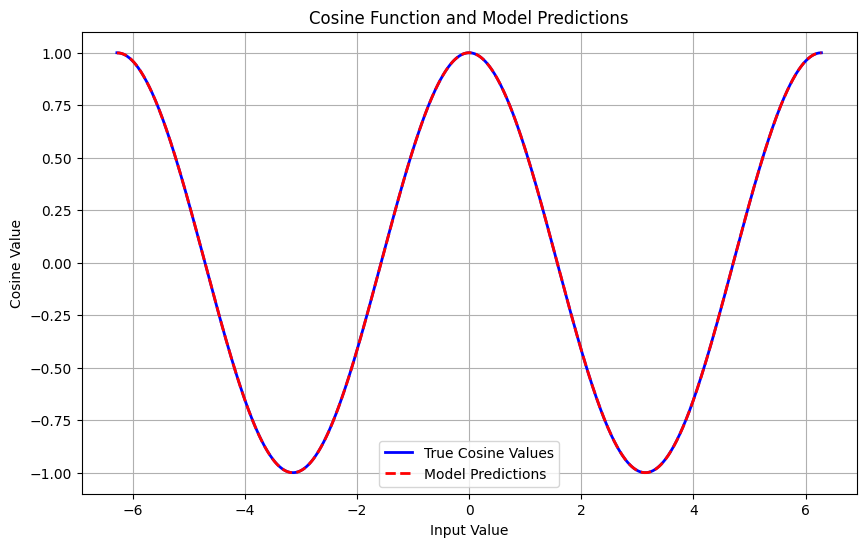

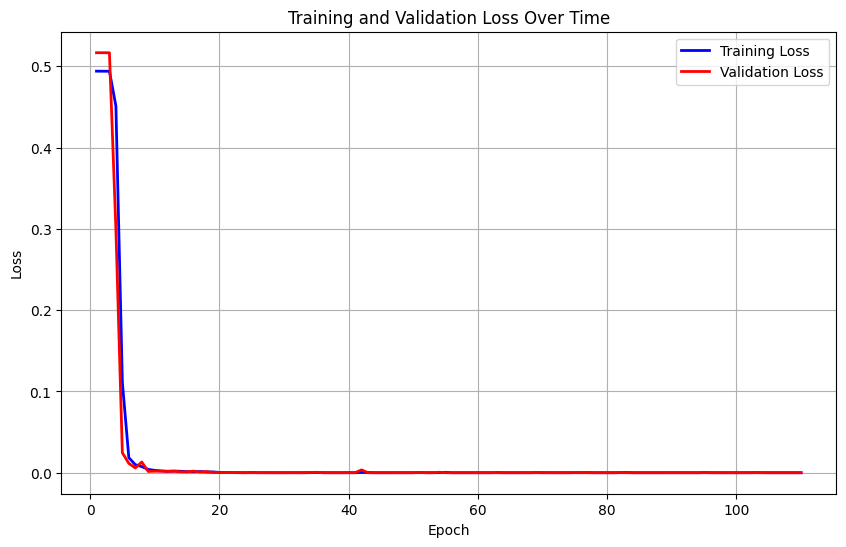

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization,Activation
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import keras.backend as K


class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

callback = StopAtThresholdCallback(threshold=1e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 

class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   

class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)
    
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)


In [ ]:
np.random.seed(42)
n_samples = 10000
lower_bound = 0
upper_bound = 1
# lower_bound = -10
# upper_bound = 10
def custom_function(x):
    return np.exp(-2*x) * np.cos(5*np.pi*x) + x

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = custom_function(X)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)

y_true = custom_function(X_test)

y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

* Epoch 150/150
* 125/125 [==============================] - 0s 3ms/step - loss: 1.4105e-05 - val_loss: 1.7452e-05
* Validation loss: 1.7452131942263804e-05
* 32/32 [==============================] - 0s 1ms/step

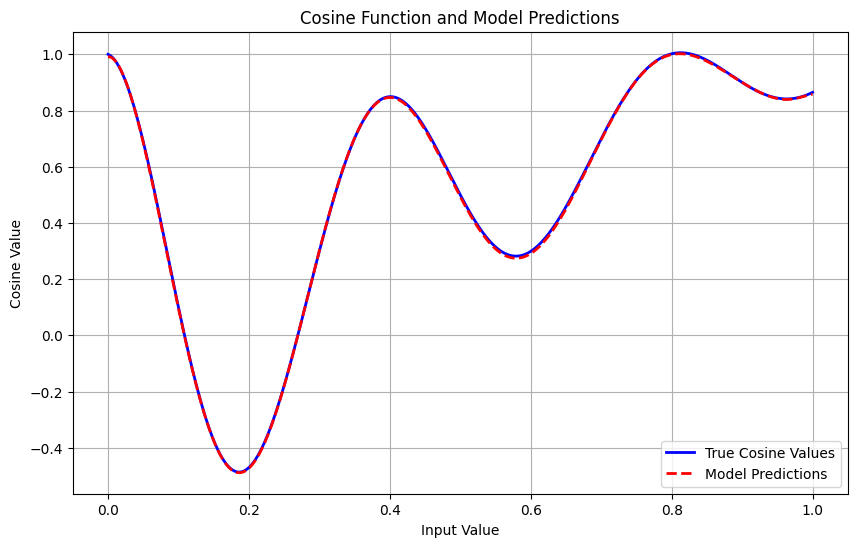

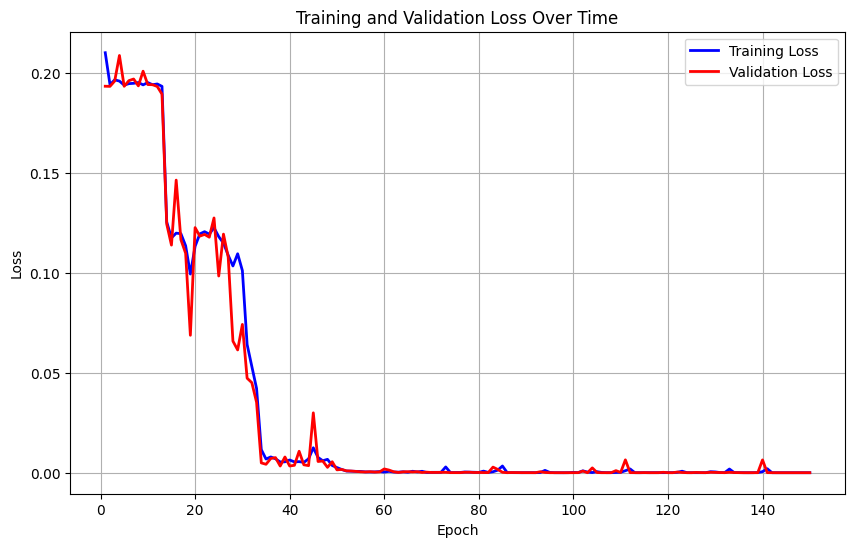

In [ ]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, Activation, concatenate,Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=1.2962e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return (self.b * (2 * x))/ (2**(1/2) * np.pi**(1/4))
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (((2*x*(self.h1(x))))-2)/(2*(np.pi**(1/4))*np.sqrt(math.factorial(2)))
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (((2 * x * (self.h2(x))))-(4 * self.h1(x))) / (2**(3/2)*(np.pi**(1/4))*np.sqrt(math.factorial(3)))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (((2*x*(self.h3(x))))-(6*self.h2(x))) / (2**2 *(np.pi**(1/4))*np.sqrt(math.factorial(4)))

class H5Layer(Layer):
    def __init__(self, **kwargs):
        super(H5Layer,self).__init__(**kwargs)

    def call(self,x, h3, h4):
        return (((2 * x * h4)) - (8 * h3)) / (2**(5/2) * (np.pi**(1/4)) * np.sqrt(math.factorial(5)))

#FROM THIS ON NO MODIFICATION ON WEIGHTS
class H6Layer(Layer):
    def __init__(self, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        
    def call(self,x, h4, h5):
        return (2*x*(h5))-(10*h4)

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)

* Epoch 150/150
* 125/125 [==============================] - 0s 3ms/step - loss: 2.5224e-05 - val_loss: 1.6129e-05
* Validation loss: 1.6128975403262302e-05
* 32/32 [==============================] - 0s 1ms/step

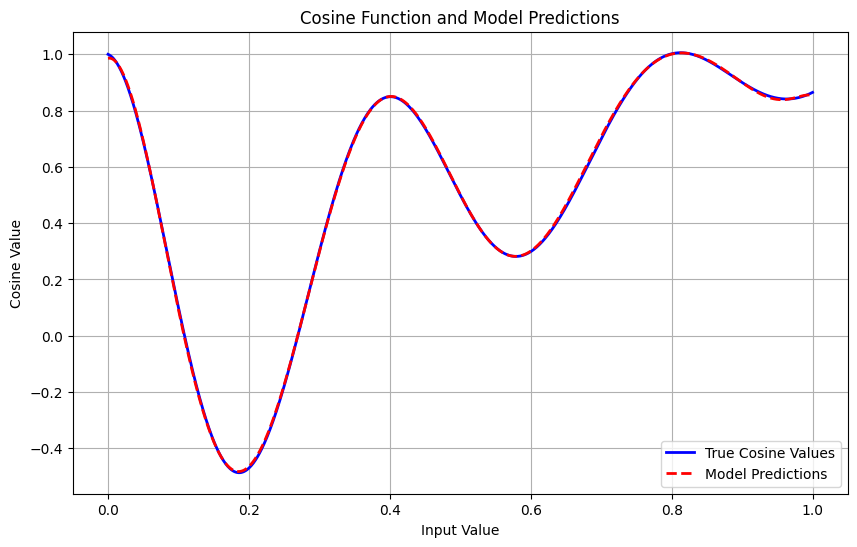

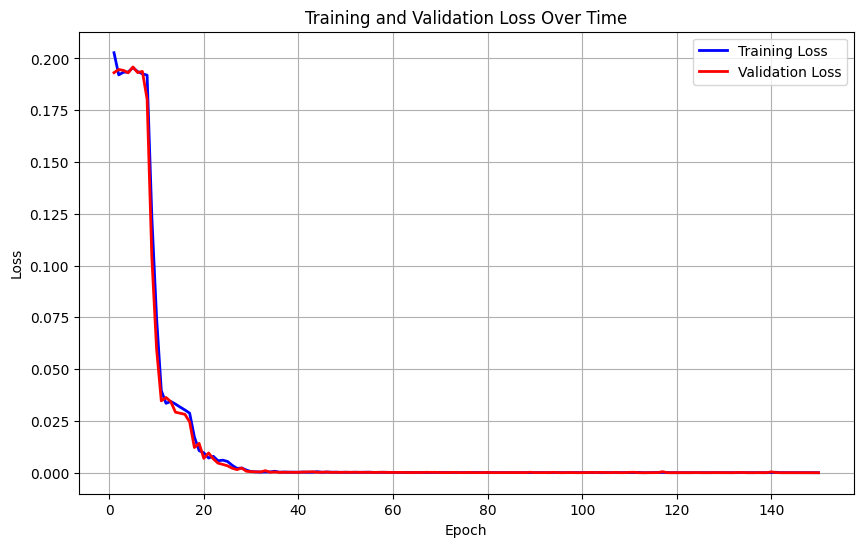